### Import Functions

In [1]:
#General Load and Save Functions
import numpy as np
import pandas as pd
from pandas import read_csv
import statistics
import csv
from math import sqrt
import matplotlib.pyplot as plt

#SKlearn packages for pre-processing the train and test data
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#XGBoost
import xgboost as xgb
from xgboost import XGBRegressor

pd.set_option("display.max_rows", None, "display.max_columns", None)

def Grouper(df,column,criteria):
    column = column
    grouped = df.groupby(df[column])
    g = grouped.get_group(criteria)
    return g

def SplitByCriteria(data,column,point):
    df = Grouper(data,column,point)
    return df


print("Import Complete")

Import Complete


### Model Code

In [29]:
def Run(data_train,data_evaluate,data_project,model,inputlist):
    dfl = []
    dflp = []
    PosList = list(set(data_train['Position'].tolist()))
    PL = [i for i in PosList if str(i) != 'nan']
    for p in PL:
        post = SplitByPosition(data_train,p)
        pose = SplitByPosition(data_evaluate,p)
        posp = SplitByPosition(data_project,p)

        IDList = ['Player','Week']
        IDs_train = post[IDList].fillna(0).values
        IDs_test = pose[IDList].fillna(0).values
        IDs_project = posp[IDList].fillna(0).values
        X_train = post[inputlist].fillna(0).values
        X_test = pose[inputlist].fillna(0).values
        X_project = posp[inputlist].fillna(0).values
        arr = IDs_test
        arrp = IDs_project
        OutputList = ['YdsPass1']
        for l in OutputList:
            train = post[l].values
            mod = model[0]
            mod.fit(X_train, train)
            preds = mod.predict(X_test).reshape(X_test.shape[0],1)
            projs = mod.predict(X_project).reshape(X_project.shape[0],1)
            arr = np.hstack((arr, preds))
            arrp = np.hstack((arrp,projs))
        df = pd.DataFrame(arr, columns=['Player','Week','OurProjection'])
        dfp = pd.DataFrame(arrp, columns=['Player','Week','OurProjection'])
        dfl.append(df)
        dflp.append(dfp)
    df = pd.concat(dfl)
    dfp = pd.concat(dflp)
    all_data_df = pd.merge(data_evaluate, df, on=['Player','Week'])
    all_data_df_proj = pd.merge(data_project, dfp, on=['Player','Week'])
    return all_data_df, all_data_df_proj

print("Model Loaded")

Model Loaded


In [19]:
def TrainModel(data,idlist,inputlist,outputvar,model):
    IDs_train = data[idlist].fillna(0).values
    X_train = data[inputlist].fillna(0).values
    train = data[outputvar].values
    mod = model[0]
    mod.fit(X_train, train)
        
    return mod

def GetPred(train,data,idlist,inputlist,outputvar,model):
    mod = TrainModel(train,idlist,inputlist,outputvar,model)
    IDs_test = data[idlist].fillna(0).values
    X_test = data[inputlist].fillna(0).values
    arr = IDs_test
    preds = mod.predict(X_test).reshape(X_test.shape[0],1)
    arr = np.hstack((arr, preds))
    df = pd.DataFrame(arr, columns=idlist + ['OurProjection'])
    df_proj = pd.merge(data, df, on=idlist)
    return df_proj

### Load Data

In [21]:
currentweek = 14
TeamName = 'MLFiends'
path = r'data\2020\\'+str(currentweek)
MDF = pd.read_csv(path+'\\Playertrain.csv')
MDF['Position'] = MDF['Pos']
MDF['Player'] = MDF['Player_x']
QBs = Grouper(MDF,'Position','QB')
TRAIN, TEST = train_test_split(QBs, test_size=0.2, random_state=42, shuffle=True)
PROJECT = Grouper(pd.read_csv(path+'\\Playerproject.csv'),'Position','QB')
        
print("Data Loaded")

Test Error: 90.204983028479
   Unnamed: 0  Unnamed: 1 Week  Year   GID                        Name Pos  \
0        1839          24   10  2020  1441        Derek CarrQB15260876  QB   
1         856          18    5  2020  1501      Dak PrescottQB15260870  QB   
2        1967          12   11  2020  1537      Kyler MurrayQB15260888  QB   
3          77           9    2  2020  1242  Ryan FitzpatrickQB15260890  QB   
4         738           2    5  2020  1537      Kyler MurrayQB15260888  QB   

  Team h/a Oppt  DK points  DK salary                    Player_x  CmpPass  \
0  lvr   h  den       7.16       5400        Derek CarrQB15260876       16   
1  dal   h  nyg      14.44       7400      Dak PrescottQB15260870       14   
2  ari   a  sea      20.26       8500      Kyler MurrayQB15260888       29   
3  mia   h  buf      27.32       5200  Ryan FitzpatrickQB15260890       31   
4  ari   a  nyj      30.30       7200      Kyler MurrayQB15260888       27   

   AttPass  Cmp%Pass  YdsPass1  TD

In [32]:
def GetRMSE(n,eta,TRAIN,TEST,idlist,inputlist,outputvar):
    model = [xgb.XGBRegressor(objective ='reg:squarederror',eta=eta, max_depth=n, n_estimators=n),"XGBoost"]
    df_proj = GetPred(TRAIN,TEST,idlist,inputlist,outputvar,model)
    RMSE = sqrt(mean_squared_error(df_proj['OurProjection'],df_proj[outputvar]))
    return RMSE

def BestRMSE(eta,TRAIN,TEST,idlist,inputlist,outputvar):
    start = int(1/eta)
    RMSE2 = 0
    RMSE1 = 1

    while RMSE1 > RMSE2:
        n = start
        RMSE1 = GetRMSE(n,eta,TRAIN,TEST,idlist,inputlist,outputvar)
        print(n,"Estimators")
        n += 1
        RMSE2 = GetRMSE(n,eta,TRAIN,TEST,idlist,inputlist,outputvar)
        start *= 2
    start = start / 2
    step = start / 2
    start += step
    while step >= 1:
        n = int(start)
        print(n,"Estimators")
        RMSE1 = GetRMSE(n,eta,TRAIN,TEST,idlist,inputlist,outputvar)
        n += 1
        RMSE2 = GetRMSE(n,eta,TRAIN,TEST,idlist,inputlist,outputvar)
        if RMSE1 > RMSE2:
            step /= 2
            start += step
        else:
            step /=2
            start -= step
    return start, RMSE1

100 Estimators
200 Estimators
400 Estimators
800 Estimators
1200 Estimators
1400 Estimators
1500 Estimators
1550 Estimators
1575 Estimators
1587 Estimators
1593 Estimators
1596 Estimators
1598 Estimators
Final N Value: 1599.21875
Final RMSE 91.23838471383814


In [39]:
currentweek = 14
TeamName = 'MLFiends'
path = r'data\2020\\'+str(currentweek)
MDF = pd.read_csv(path+'\\Playertrain.csv')
MDF['Position'] = MDF['Pos']
MDF['Player'] = MDF['Player_x']
QBs = Grouper(MDF,'Position','QB')
QBs = QBs[QBs['CmpPass'] > 9]
#TRAIN, TEST = train_test_split(QBs, test_size=0.2, random_state=42, shuffle=True)
TRAIN = QBs[QBs['Week'] < currentweek]
TEST = Grouper(QBs,'Week',currentweek)
PROJECT = Grouper(pd.read_csv(path+'\\Playerproject.csv'),'Position','QB')

#Target_Columns = [col for col in TRAIN.columns if 'CALCAVGPPDOFF' in col or 'CALCAVGPTDOPP' in col]
Target_Columns = [col for col in TRAIN.columns if 'CALCAVG' in col]

idlist = ['Player','Week']
eta = 0.01
start, RMSE1 = BestRMSE(eta,TRAIN,TEST,['Player','Week'],Target_Columns,['YdsPass1'])
print("Final N Value:",start)
print("Final RMSE",RMSE1)

100 Estimators
200 Estimators
400 Estimators
600 Estimators
500 Estimators
450 Estimators
425 Estimators
412 Estimators
406 Estimators
403 Estimators
401 Estimators
Final N Value: 400.78125
Final RMSE 75.8202967869882


In [46]:
eta = 0.01
n = 400
columnlist = ['Player','OurProjection','CALCAVGPPDOFFYdsPass1','YdsPass1']
model = [xgb.XGBRegressor(objective ='reg:squarederror',eta=eta, max_depth=n, n_estimators=n),"XGBoost"]
df_proj = GetPred(TRAIN,TEST,idlist,Target_Columns,['YdsPass1'],model)
df_proj = df_proj[columnlist]
print(df_proj)

df_proj.to_csv("ProjDataframe.csv")

eta = 0.01
n = 400
columnlist = ['Player','OurProjection','CALCAVGPPDOFFYdsPass1']
model = [xgb.XGBRegressor(objective ='reg:squarederror',eta=eta, max_depth=n, n_estimators=n),"XGBoost"]
df_proj = GetPred(TRAIN,PROJECT,idlist,Target_Columns,['YdsPass1'],model)
df_proj = df_proj[columnlist]
#print(df_proj)

                          Player OurProjection  CALCAVGPPDOFFYdsPass1  \
0        Aaron RodgersQB15260875       312.941             291.250000   
1           Derek CarrQB15260876       256.898             257.250000   
2            Drew LockQB15260873       216.364             218.800000   
3    Mitchell TrubiskyQB15260864       238.594             165.400000   
4      Patrick MahomesQB15260868        305.24             308.416667   
5       Russell WilsonQB15260881        293.37             287.166667   
6          Taysom HillQB15260880        242.22              65.333333   
7    Teddy BridgewaterQB15260878       191.254             255.200000   
8           Josh AllenQB15260861       206.109             295.090909   
9         Kyler MurrayQB15260888       254.092             257.166667   
10        Kirk CousinsQB15260877       291.142             256.666667   
11       Philip RiversQB15260867       292.014             271.333333   
12      Deshaun WatsonQB15260889       316.526     

### Extreme Gradient Boosted Model

10 Estimators
Test Error: 139.48317800099565
20 Estimators
Test Error: 113.01054489751763
30 Estimators
Test Error: 106.81724646777259
40 Estimators
Test Error: 104.99527967027728
50 Estimators
Test Error: 104.39376645616122
60 Estimators
Test Error: 104.14473075832262
70 Estimators
Test Error: 104.01249921183381
80 Estimators
Test Error: 104.004685139568
90 Estimators
Test Error: 103.97190008956919


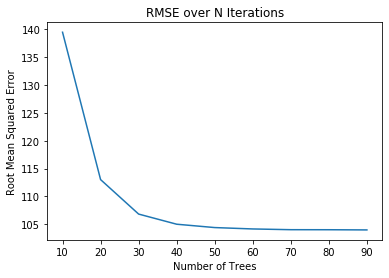

In [4]:
start = 10
stop = 100
step = 10
NList = [n for n in range(start,stop,step)]
RMSEList = []
NUsed = []
BTE = 10000
for n in NList:
    print(n,"Estimators")
    model = [xgb.XGBRegressor(objective ='reg:squarederror',eta=0.1, max_depth=n, n_estimators = n),"XGBoost"]
    all_data_df, all_data_df_proj = Run(TRAIN,TEST,PROJECT,model,Target_Columns)
    RMSE = sqrt(mean_squared_error(all_data_df['OurProjection'],all_data_df['YdsPass1']))
    print("Test Error:", RMSE)
    RMSEList.append(RMSE)
    NUsed.append(n)
    all_data_df.to_csv(path+'\Projections.csv')
    all_data_df_proj.to_csv(path+'\\'+TeamName+'.csv')
    if RMSE < BTE:
        BTE = RMSE
    else:
        break

plt.plot(NUsed,RMSEList)
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Number of Trees')
plt.title('RMSE over N Iterations')
plt.show()

In [28]:
eta=0.1
start = int(1/eta)
RMSE1 = 2
RMSE2 = 1

while RMSE1 > RMSE2:
    n = start
    print(n,"Estimators")
    model = [xgb.XGBRegressor(objective ='reg:squarederror',eta=eta, max_depth=n, n_estimators=n),"XGBoost"]
    all_data_df, all_data_df_proj = Run(TRAIN,TEST,PROJECT,model,Target_Columns)
    RMSE1 = sqrt(mean_squared_error(all_data_df['OurProjection'],all_data_df['YdsPass1']))
    n += 1
    model = [xgb.XGBRegressor(objective ='reg:squarederror',eta=eta, max_depth=n, n_estimators=n),"XGBoost"]
    all_data_df, all_data_df_proj = Run(TRAIN,TEST,PROJECT,model,Target_Columns)
    RMSE2 = sqrt(mean_squared_error(all_data_df['OurProjection'],all_data_df['YdsPass1']))
    start *= 2
upperbound = start
start = start / 2
step = start / 2
start += step
while step >= 1:
    n = int(start)
    print(n,"Estimators")
    model = [xgb.XGBRegressor(objective ='reg:squarederror',eta=eta, max_depth=n, n_estimators=n),"XGBoost"]
    all_data_df, all_data_df_proj = Run(TRAIN,TEST,PROJECT,model,Target_Columns)
    RMSE1 = sqrt(mean_squared_error(all_data_df['OurProjection'],all_data_df['YdsPass1']))
    n += 1
    model = [xgb.XGBRegressor(objective ='reg:squarederror',eta=eta, max_depth=n, n_estimators=n),"XGBoost"]
    all_data_df, all_data_df_proj = Run(TRAIN,TEST,PROJECT,model,Target_Columns)
    RMSE2 = sqrt(mean_squared_error(all_data_df['OurProjection'],all_data_df['YdsPass1']))
    if RMSE1 > RMSE2:
        step /= 2
        start += step
    else:
        step /=2
        start -= step
    

print("Final Values")
print(start)
print(RMSE1)
print(RMSE2)  

10 Estimators


TypeError: Run() missing 1 required positional argument: 'output_variable'

In [30]:
eta=0.1
start = int(1/eta)
RMSE1 = 2
RMSE2 = 1

while RMSE1 > RMSE2:
    n = start
    print(n,"Estimators")
    model = [xgb.XGBRegressor(objective ='reg:squarederror',eta=eta, max_depth=n, n_estimators=n),"XGBoost"]
    all_data_df, all_data_df_proj = Run(TRAIN,TEST,PROJECT,model,Target_Columns)
    RMSE1 = sqrt(mean_squared_error(all_data_df['OurProjection'],all_data_df['YdsPass1']))
    n += 1
    model = [xgb.XGBRegressor(objective ='reg:squarederror',eta=eta, max_depth=n, n_estimators=n),"XGBoost"]
    all_data_df, all_data_df_proj = Run(TRAIN,TEST,PROJECT,model,Target_Columns)
    RMSE2 = sqrt(mean_squared_error(all_data_df['OurProjection'],all_data_df['YdsPass1']))
    start *= 2
upperbound = start
start = start / 2
step = start / 2
start += step
while step >= 1:
    n = int(start)
    print(n,"Estimators")
    model = [xgb.XGBRegressor(objective ='reg:squarederror',eta=eta, max_depth=n, n_estimators=n),"XGBoost"]
    all_data_df, all_data_df_proj = Run(TRAIN,TEST,PROJECT,model,Target_Columns)
    RMSE1 = sqrt(mean_squared_error(all_data_df['OurProjection'],all_data_df['YdsPass1']))
    n += 1
    model = [xgb.XGBRegressor(objective ='reg:squarederror',eta=eta, max_depth=n, n_estimators=n),"XGBoost"]
    all_data_df, all_data_df_proj = Run(TRAIN,TEST,PROJECT,model,Target_Columns)
    RMSE2 = sqrt(mean_squared_error(all_data_df['OurProjection'],all_data_df['YdsPass1']))
    if RMSE1 > RMSE2:
        step /= 2
        start += step
    else:
        step /=2
        start -= step
    

print("Final Values")
print(start)
print(RMSE1)
print(RMSE2)

10 Estimators
20 Estimators
40 Estimators
80 Estimators
160 Estimators
320 Estimators
480 Estimators
400 Estimators
360 Estimators
340 Estimators
330 Estimators
325 Estimators
322 Estimators
321 Estimators
Final Values
320.625
90.20498302728859
90.20498302780211
